# Movie Database Preprocessing

### Import the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset
from surprise import Reader, KNNWithMeans, SVD
from ast import literal_eval
from surprise.model_selection import GridSearchCV, cross_validate
from surprise import accuracy
from wordcloud import WordCloud, STOPWORDS 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel 

In [2]:
df = pd.read_csv('movies_metadata.csv',low_memory=False)
credits = pd.read_csv('credits.csv',low_memory=False)
ratings = pd.read_csv('ratings_small.csv',low_memory=False)
df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [3]:
df.shape

(45466, 24)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
adult                    45466 non-null object
belongs_to_collection    4494 non-null object
budget                   45466 non-null object
genres                   45466 non-null object
homepage                 7782 non-null object
id                       45466 non-null object
imdb_id                  45449 non-null object
original_language        45455 non-null object
original_title           45466 non-null object
overview                 44512 non-null object
popularity               45461 non-null object
poster_path              45080 non-null object
production_companies     45463 non-null object
production_countries     45463 non-null object
release_date             45379 non-null object
revenue                  45460 non-null float64
runtime                  45203 non-null float64
spoken_languages         45460 non-null object
status                   45379 non-null objec

In [5]:
df.describe()

,revenue,runtime,vote_average,vote_count
count,4.546000e+04,45203.000000,45460.000000,45460.000000
mean,1.120935e+07,94.128199,5.618207,109.897338
std,6.433225e+07,38.407810,1.924216,491.310374
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,107.000000,6.800000,34.000000
max,2.787965e+09,1256.000000,10.000000,14075.000000


In [6]:
df.describe(include=[np.object])

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,spoken_languages,status,tagline,title,video
count,45466,4494,45466,45466,7782,45466,45449,45455,45466,44512,45461,45080,45463,45463,45379,45460,45379,20412,45460,45460
unique,5,1698,1226,4069,7673,45436,45417,92,43373,44307,43758,45024,22708,2393,17336,1931,6,20283,42277,2
top,False,"{'id': 415931, 'name': 'The Bowery Boys', 'pos...",0,"[{'id': 18, 'name': 'Drama'}]",http://www.georgecarlin.com,141971,0,en,Hamlet,No overview found.,0.0,/5D7UBSEgdyONE6Lql6xS7s6OLcW.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2008-01-01,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Cinderella,False
freq,45454,29,36573,5000,12,3,3,32269,8,133,66,5,11875,17851,136,22395,45014,7,11,45367


In [7]:
df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

### Univariate Analysis

This involves the analysis of each single variable and tries to summarise and find the patterns in the data.

In [9]:
df['adult'].value_counts()

False                                                                                                                             45454
True                                                                                                                                  9
 - Written by Ørnås                                                                                                                   1
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
Name: adult, dtype: int64

This feature is higly imbalanced since its majority is False. Hence, this will not help in analysis of the data.

In [10]:
df['belongs_to_collection'].value_counts()

{'id': 415931, 'name': 'The Bowery Boys', 'poster_path': '/q6sA4bzMT9cK7EEmXYwt7PNrL5h.jpg', 'backdrop_path': '/foe3kuiJmg5AklhtD3skWbaTMf2.jpg'}                 29
{'id': 421566, 'name': 'Totò Collection', 'poster_path': '/4ayJsjC3djGwU9eCWUokdBWvdLC.jpg', 'backdrop_path': '/jaUuprubvAxXLAY5hUfrNjxccUh.jpg'}                 27
{'id': 96887, 'name': 'Zatôichi: The Blind Swordsman', 'poster_path': '/8Q31DAtmFJjhFTwQGXghBUCgWK2.jpg', 'backdrop_path': '/bY8gLImMR5Pr9PaG3ZpobfaAQ8N.jpg'}    26
{'id': 645, 'name': 'James Bond Collection', 'poster_path': '/HORpg5CSkmeQlAolx3bKMrKgfi.jpg', 'backdrop_path': '/6VcVl48kNKvdXOZfJPdarlUGOsk.jpg'}               26
{'id': 37261, 'name': 'The Carry On Collection', 'poster_path': '/2P0HNrYgKDvirV8RCdT1rBSJdbJ.jpg', 'backdrop_path': '/38tF1LJN7ULeZAuAfP7beaPMfcl.jpg'}          25
                                                                                                                                                                  ..
{'id': 429

This feature contains multiple data values stored in a json format. Extract the name attribute and add it as a new feature or replace the existing feature.

In [11]:
def literal_return(val):
    try:
        return literal_eval(val)
    except ValueError:
        return (val)

In [12]:
df['franchise'] = df['belongs_to_collection']
df['franchise'] = df['franchise'].apply(literal_return).apply(lambda x: x['name'] if isinstance(x, dict) else np.nan)
print (df[['franchise']].head(10))

                        franchise
0            Toy Story Collection
1                             NaN
2       Grumpy Old Men Collection
3                             NaN
4  Father of the Bride Collection
5                             NaN
6                             NaN
7                             NaN
8                             NaN
9           James Bond Collection


#### Top 15 Movies with maximum number of sequels released

In [13]:
df['franchise'].value_counts().head(15)

The Bowery Boys                           29
Totò Collection                           27
James Bond Collection                     26
Zatôichi: The Blind Swordsman             26
The Carry On Collection                   25
Pokémon Collection                        22
Charlie Chan (Sidney Toler) Collection    21
Godzilla (Showa) Collection               16
Charlie Chan (Warner Oland) Collection    15
Dragon Ball Z (Movie) Collection          15
Uuno Turhapuro                            15
Monster High Collection                   14
The Land Before Time Collection           14
George Carlin Comedy Collection           13
Sharpe Collection                         13
Name: franchise, dtype: int64

In [14]:
def to_int(val):
    try:
        return int(val)
    except:
        return np.nan

The budget field is given as an object. So convert it into integer. The budget of a movie cannot be 0 and hence replace this with NaN

In [16]:
#df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['budget'] = df['budget'].apply(to_int)
df['budget'].replace(0,np.nan,inplace=True)
df['budget'].isna().sum()

36576

Check if id column has any null values and remove Null values

In [17]:
df['id'] = df['id'].apply(to_int)
df[df['id'].isnull()]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,franchise
19730,- Written by Ørnås,0.065736,NaN,"[{'name': 'Carousel Productions', 'id': 11176}...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",NaN,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,1.931659,NaN,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,NaN,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",NaN,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
index = np.where(df['id'].isna())[0]
index
df.drop(index,axis=0,inplace=True)

Find all the columns with NaN values

In [20]:
df.isna().sum()

adult                        0
belongs_to_collection    40972
budget                   36573
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   3
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      3
runtime                    260
spoken_languages             3
status                      84
tagline                  25051
title                        3
video                        3
vote_average                 3
vote_count                   3
franchise                40972
dtype: int64

There are few columns like "title", "vote_average" and "vote_count" which contains NaN values. Remove the rows with null values.

In [21]:
df = df.dropna(subset=['title']).reset_index(drop=True)

Convert the genres columns to list

In [22]:
df['genres'] = [list(set([y['name'] for y in x])) for x in df['genres'].apply(literal_eval)]
print (df[['genres'] ].head(10))

                               genres
0         [Animation, Comedy, Family]
1        [Family, Fantasy, Adventure]
2                   [Romance, Comedy]
3            [Romance, Drama, Comedy]
4                            [Comedy]
5    [Crime, Drama, Thriller, Action]
6                   [Romance, Comedy]
7  [Family, Drama, Adventure, Action]
8       [Thriller, Adventure, Action]
9       [Thriller, Adventure, Action]


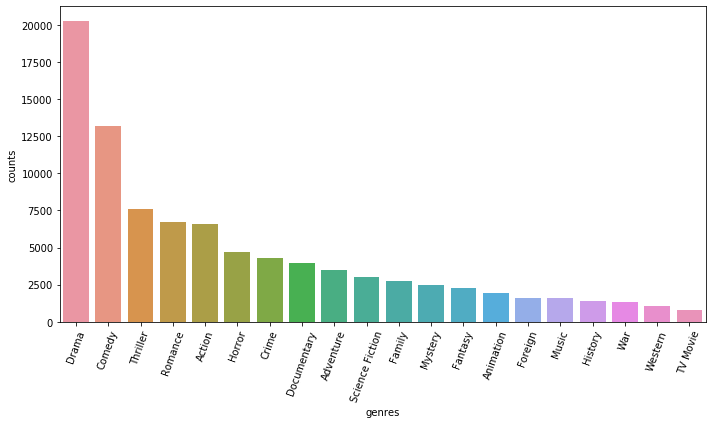

In [46]:
df1 = df['genres'].explode().value_counts().rename_axis('genres').reset_index(name='counts')
plt.figure(figsize=(10,6))
sns.barplot(x="genres",y="counts",data=df1)
plt.xticks(rotation=70)
plt.tight_layout()

In [23]:
df[df['homepage'].isna() == False].head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,franchise
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862.0,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,Toy Story Collection
9,False,"{'id': 645, 'name': 'James Bond Collection', '...",58000000.0,"[Thriller, Adventure, Action]",http://www.mgm.com/view/movie/757/Goldeneye/,710.0,tt0113189,en,GoldenEye,James Bond must unmask the mysterious head of ...,...,352194034.0,130.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,No limits. No fears. No substitutes.,GoldenEye,False,6.6,1194.0,James Bond Collection
24,False,NaN,3600000.0,"[Drama, Romance]",http://www.mgm.com/title_title.do?title_star=L...,451.0,tt0113627,en,Leaving Las Vegas,"Ben Sanderson, an alcoholic Hollywood screenwr...",...,49800000.0,112.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,I Love You... The Way You Are.,Leaving Las Vegas,False,7.1,365.0,NaN
46,False,NaN,33000000.0,"[Crime, Thriller, Mystery]",http://www.sevenmovie.com/,807.0,tt0114369,en,Se7en,Two homicide detectives are on a desperate hun...,...,327311859.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Seven deadly sins. Seven ways to die.,Se7en,False,8.1,5915.0,NaN
49,False,NaN,6000000.0,"[Crime, Drama, Thriller]",http://www.mgm.com/#/our-titles/2083/The-Usual...,629.0,tt0114814,en,The Usual Suspects,"Held in an L.A. interrogation room, Verbal Kin...",...,23341568.0,106.0,"[{'iso_639_1': 'es', 'name': 'Español'}, {'iso...",Released,Five Criminals. One Line Up. No Coincidence.,The Usual Suspects,False,8.1,3334.0,NaN


#### Most Popular Language in Movies

In [25]:
df['original_language'].nunique()

89

There are almost 89 unique languages in this database. English is the most popular language. Apart from English, the most popular languages are:

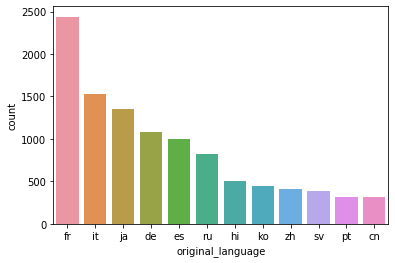

In [24]:
sns.countplot("original_language",data=df, order=df['original_language'].value_counts().iloc[1:13].index)

In [26]:
df[df['original_language'].isna() == True][['title', 'original_title','spoken_languages']]

,title,original_title,spoken_languages
19574,Shadowing the Third Man,Shadowing the Third Man,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso..."
21600,Unfinished Sky,Unfinished Sky,"[{'iso_639_1': 'en', 'name': 'English'}]"
22830,13 Fighting Men,13 Fighting Men,"[{'iso_639_1': 'en', 'name': 'English'}]"
32137,Lambchops,Lambchops,"[{'iso_639_1': 'en', 'name': 'English'}]"
37401,Prince Bayaya,Bajaja,"[{'iso_639_1': 'cs', 'name': 'Český'}]"
41041,Song of Lahore,Song of Lahore,"[{'iso_639_1': 'ur', 'name': 'اردو'}, {'iso_63..."
41866,Annabelle Serpentine Dance,Annabelle Serpentine Dance,"[{'iso_639_1': 'xx', 'name': 'No Language'}]"
44051,Lettre d'une inconnue,Lettre d'une inconnue,"[{'iso_639_1': 'fr', 'name': 'Français'}]"
44404,Yarn,Garn,"[{'iso_639_1': 'sv', 'name': 'svenska'}, {'iso..."
44570,WiNWiN,WiNWiN,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso..."


In [27]:
df[df['runtime'] <= 0 ][['title','runtime']]

,title,runtime
222,Dream Man,0.0
224,Destiny Turns on the Radio,0.0
398,Dos Crímenes,0.0
554,"The Beans of Egypt, Maine",0.0
667,The Run of the Country,0.0
...,...,...
45364,How Most Things Work,0.0
45365,LEGO DC Super Hero Girls: Brain Drain,0.0
45393,All at Once,0.0
45410,"Whiffles, Cubic Artist",0.0


Replace the 'Runtime' column where value is 0.

In [28]:
df['runtime'].replace(0,np.nan,inplace=True)
df['runtime'].isna().sum()

1815

Drop columns which are not relevant for the Recommendation algorithms.

In [30]:
features= ['adult','belongs_to_collection','homepage','imdb_id','original_title','poster_path','video']
df = df.drop(features, axis=1)
df.head()

,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,franchise
0,30000000.0,"[Animation, Comedy, Family]",862.0,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,7.7,5415.0,Toy Story Collection
1,65000000.0,"[Family, Fantasy, Adventure]",8844.0,en,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,NaN
2,NaN,"[Romance, Comedy]",15602.0,en,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,Grumpy Old Men Collection
3,16000000.0,"[Romance, Drama, Comedy]",31357.0,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,NaN
4,NaN,[Comedy],11862.0,en,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,Father of the Bride Collection


In [31]:
df['revenue'].value_counts()

0.0            38052
12000000.0        20
10000000.0        19
11000000.0        19
2000000.0         18
               ...  
245724603.0        1
12212123.0         1
8203235.0          1
25900.0            1
12032983.0         1
Name: revenue, Length: 6863, dtype: int64

In [32]:
df['revenue'].replace(0,np.nan,inplace=True)
df['revenue'].isna().sum()

38052

In [33]:
df['spoken_languages'] = df['spoken_languages'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df['spoken_languages'].explode().value_counts().head(20)

English            28745
Français            4196
Deutsch             2625
Español             2413
Italiano            2367
                   ...  
Kinyarwanda            3
ozbek                  2
Fulfulde               2
беларуская мова        2
Hausa                  1
Name: sl, Length: 75, dtype: int64

In [35]:
df["status"].value_counts()

Released           45014
Rumored              230
Post Production       98
In Production         20
Planned               15
Canceled               2
Name: status, dtype: int64

There are 2 movies which are cancelled. We dont need movies which are cancelled.

In [36]:
values = ["Canceled"]
index = np.where(df['status'].isin(values))[0]
index

array([33353, 40415], dtype=int64)

In [37]:
df.drop(index,inplace=True)
df = df.reset_index(drop=True)

#### Drop Duplicate Rows

In [39]:
features= ['id','overview', 'vote_count', 'vote_average']
duplicateRowsDF = df[df.duplicated(features)]
duplicateRowsDF.sort_values('id').shape

(28, 19)

In [45]:
df.drop_duplicates(features,inplace=True)
df = df.reset_index(drop=True)
df

,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,franchise,sl
0,30000000.0,"[Animation, Comedy, Family]",862.0,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,7.7,5415.0,Toy Story Collection,[English]
1,65000000.0,"[Family, Fantasy, Adventure]",8844.0,en,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,NaN,"[English, Français]"
2,NaN,"[Romance, Comedy]",15602.0,en,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,NaN,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,Grumpy Old Men Collection,[English]
3,16000000.0,"[Romance, Drama, Comedy]",31357.0,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,NaN,[English]
4,NaN,[Comedy],11862.0,en,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,Father of the Bride Collection,[English]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45425,NaN,"[Drama, Family]",439050.0,fa,Rising and falling between a man and woman.,0.072051,[],"[{'iso_3166_1': 'IR', 'name': 'Iran'}]",NaN,NaN,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,4.0,1.0,NaN,[فارسی]
45426,NaN,[Drama],111109.0,tl,An artist struggles to finish his work while a...,0.178241,"[{'name': 'Sine Olivia', 'id': 19653}]","[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2011-11-17,NaN,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,9.0,3.0,NaN,[]
45427,NaN,"[Drama, Thriller, Action]",67758.0,en,"When one of her hits goes wrong, a professiona...",0.903007,"[{'name': 'American World Pictures', 'id': 6165}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2003-08-01,NaN,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,3.8,6.0,NaN,[English]
45428,NaN,[],227506.0,en,"In a small town live two brothers, one a minis...",0.003503,"[{'name': 'Yermoliev', 'id': 88753}]","[{'iso_3166_1': 'RU', 'name': 'Russia'}]",1917-10-21,NaN,87.0,[],Released,NaN,Satan Triumphant,0.0,0.0,NaN,[]


#### Data Exploration of Text Data

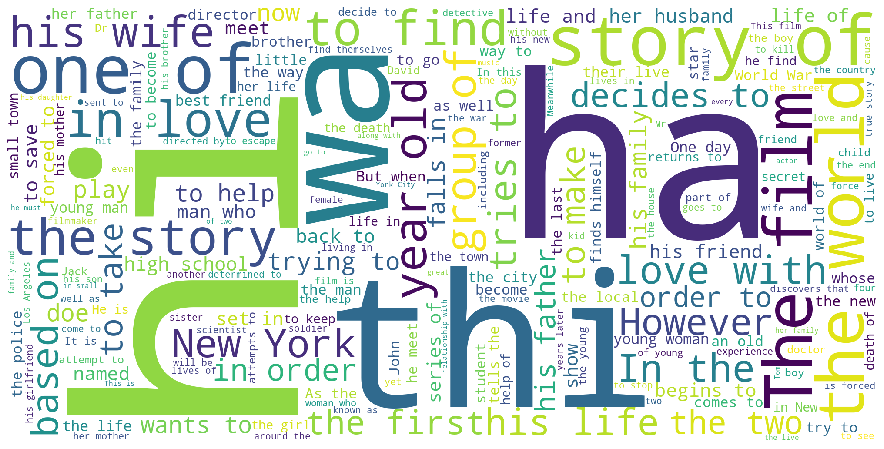

In [47]:
overview_text = ''.join(df['overview'].astype(str))
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=1000, width=2000).generate(overview_text)
#WordCloud(stopwords=STOPWORDS, background_color="white").generate(text)
plt.figure(figsize = (16, 8),  facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

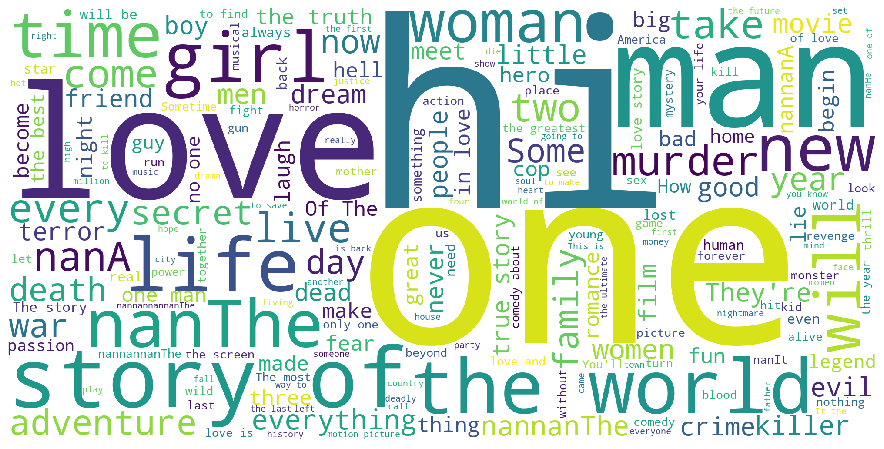

In [48]:
tagtext = ''.join(df['tagline'].astype(str))
wordcloud = WordCloud(height=1000, width=2000, stopwords=STOPWORDS, background_color='white').generate(tagtext)
#WordCloud(stopwords=STOPWORDS, background_color="white").generate(text)
plt.figure(figsize = (16, 8),  facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

These are the most common words in the overview and tagline text.

In [69]:
df['popularity'] = df['popularity'].astype('float')

#### Plot histogram to calculate the number of ratings "rating_counts" column.

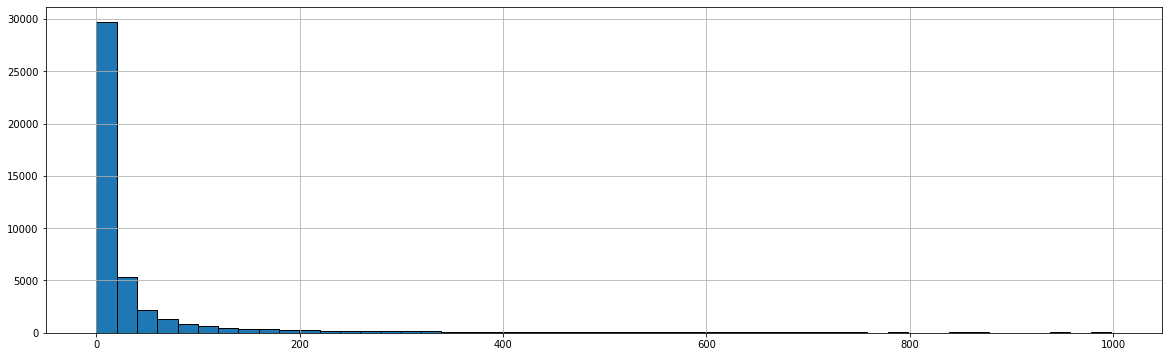

In [78]:
plt.figure(figsize=(20,6))
plt.rcParams['patch.force_edgecolor'] = True
df['vote_count'][df['vote_count'] < 1000].hist(bins=50)

In [63]:
df['vote_count'].value_counts().sort_index()

0.0        2896
1.0        3262
2.0        3132
3.0        2781
4.0        2478
           ... 
11444.0       1
12000.0       1
12114.0       1
12269.0       1
14075.0       1
Name: vote_count, Length: 1820, dtype: int64

Most of the vote_counts is below 200. There are a few movies which have vote count more than 500 but it is relatively small.

#### Plot histogram for average ratings "vote_average" column.

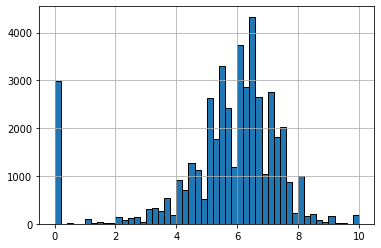

In [55]:
df['vote_average'].hist(bins=50)

Most of the ratings are either 0 or between 6.5 to 7.5

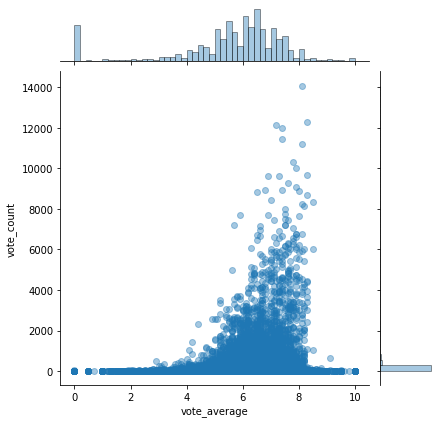

In [150]:
sns.jointplot(x='vote_average', y='vote_count', data=df, alpha=0.4)

Generally good movies have more ratings and more people tend to rate good movies. As seen in the graph, movies with higher average ratings actually have more number of ratings, compared with movies that have lower average ratings.

#### Find corelation between different features

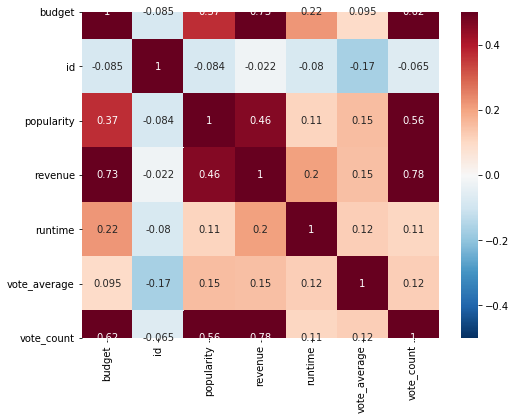

In [70]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(8, 6))
#ax.set_ylim(len(df2)-1.5, -1.5)
#f.set_size_inches(15, 12.5)
sns.heatmap(corrmat,cmap='RdBu_r',annot=True,vmax=0.5,vmin=-0.5)

The most important correlation is revenue and vote_count. The movies with higher revenue (highly successful) have a higher vote_count.

#### Most Popular Movies in terms of Popularity Score

In [56]:
df[['title','popularity']].sort_values(by='popularity', ascending=False).head(15)

,title,popularity
38546,Hyper Sapien: People from Another Star,9e-06
34286,Chameli Ki Shaadi,9e-06
536,Blade Runner,96.272374
3492,Dinosaur,9.998415
10514,Jarhead,9.997032
11249,The Last Kiss,9.996541
18021,Dream House,9.995617
1360,Hamlet,9.994088
12050,"4 Months, 3 Weeks and 2 Days",9.990406
12484,Black Dawn,9.989719


In [71]:
df.sort_values(by="popularity",ascending=False)[["title","popularity","vote_count","vote_average"]].head(15)

,title,popularity,vote_count,vote_average
30675,Minions,547.488298,4729.0,6.4
33331,Wonder Woman,294.337037,5025.0,7.2
42188,Beauty and the Beast,287.253654,5530.0,6.8
43610,Baby Driver,228.032744,2083.0,7.2
24437,Big Hero 6,213.849907,6289.0,7.8
26545,Deadpool,187.860492,11444.0,7.4
26547,Guardians of the Galaxy Vol. 2,185.330992,4858.0,7.6
14546,Avatar,185.070892,12114.0,7.2
24333,John Wick,183.870374,5499.0,7.0
23657,Gone Girl,154.801009,6023.0,7.9


In [72]:
df.sort_values(by="vote_count",ascending=False)[["title","popularity","vote_count","vote_average"]].head(15)

,title,popularity,vote_count,vote_average
15474,Inception,29.108149,14075.0,8.1
12477,The Dark Knight,123.167259,12269.0,8.3
14546,Avatar,185.070892,12114.0,7.2
17810,The Avengers,89.887648,12000.0,7.4
26545,Deadpool,187.860492,11444.0,7.4
22863,Interstellar,32.213481,11187.0,8.1
20041,Django Unchained,19.785025,10297.0,7.8
23735,Guardians of the Galaxy,53.291601,10014.0,7.9
2842,Fight Club,63.869599,9678.0,8.3
18236,The Hunger Games,20.031667,9634.0,6.9


Movies like Inception, The Dark Knight are examples of really successful movies as they have really high vote_average despite a large number of people voting.

In [73]:
df.sort_values(by="vote_average",ascending=False)[["title","popularity","vote_count","vote_average"]].head(15)

,title,popularity,vote_count,vote_average
41612,Big Jay Oakerson: Live at Webster Hall,0.248238,1.0,10.0
33363,The Italian Key,0.059830,1.0,10.0
11382,Joe Cocker - Mad Dogs & Englishmen,0.035284,1.0,10.0
41845,Panorama of Esplanade by Night,0.066255,1.0,10.0
22379,Marvin Hamlisch: What He Did For Love,0.371755,1.0,10.0
22380,Meat the Truth,0.091080,1.0,10.0
11047,Blessed Event,0.090803,1.0,10.0
33601,Mad As Hell,0.027705,1.0,10.0
22562,Eggshells,0.055097,1.0,10.0
42102,The Black Sheep of Whitehall,0.153100,1.0,10.0


These are the examples of less popular movies even though they have a high vote_average.

#### Most successful movies in terms of Revenue

In [74]:
df.sort_values(by="revenue",ascending=False)[["title","revenue","budget","vote_count","vote_average"]].head(15)

,title,revenue,budget,vote_count,vote_average
14546,Avatar,2.787965e+09,237000000.0,12114.0,7.2
26536,Star Wars: The Force Awakens,2.068224e+09,245000000.0,7993.0,7.5
1638,Titanic,1.845034e+09,200000000.0,7770.0,7.5
17810,The Avengers,1.519558e+09,220000000.0,12000.0,7.4
25065,Jurassic World,1.513529e+09,150000000.0,8842.0,6.5
28810,Furious 7,1.506249e+09,190000000.0,4253.0,7.3
26539,Avengers: Age of Ultron,1.405404e+09,280000000.0,6908.0,7.3
17429,Harry Potter and the Deathly Hallows: Part 2,1.342000e+09,125000000.0,6141.0,7.9
22095,Frozen,1.274219e+09,150000000.0,5440.0,7.3
42188,Beauty and the Beast,1.262886e+09,160000000.0,5530.0,6.8
